# Part 1: Bayesian Classification
This programming assignment has two parts. In the first part, you will build two predictive models for classification using linear discriminant analysis and quadratic discriminant analysis.

As before, your implementation should only go under the # TODO sections. Do not modify any other part of the notebook.

In [1]:
# Package imports
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
from scipy.stats import multivariate_normal as multN
import pandas as pan

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# Initialize random seed - for reproducibility. DO NOT CHANGE
np.random.seed(0)

## Generating the dataset

We will generate a toy dataset using the Scikit datasets library. This dataset has two classes, plotted as red and blue points. The data is collected in $X$ and $y$ variables, where $X$ is a $Nx2$ dimensional matrix where each row represents a data point with 2 features, i.e.
$$
X = \left[
\begin{array}{c}
    {x^{(1)}}^T \\
    {x^{(2)}}^T \\
    \vdots \\
     {x^{(N)}}^T
\end{array}
\right] 
=\left[
\begin{array}{cc}
    x_1^{(1)} & x_{2}^{(1)} \\
    x_1^{(2)} & x_{2}^{(2)} \\
    \vdots & \vdots \\
    x_1^{(N)} & x_{2}^{(N)} 
\end{array}
\right]
$$

The $y$ variable is a $Nx1$ vector such that the $i^{th}$ element represents the class (0 or 1) of the datapoint in the $i^{th}$ row of $X$. The dataset is split into a train set on which you will train your classifiers, and a test set on which you will evaluate the classifiers.

C:\Users\jorda\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  import sys
C:\Users\jorda\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: covariance is not positive-semidefinite.
  if sys.path[0] == '':


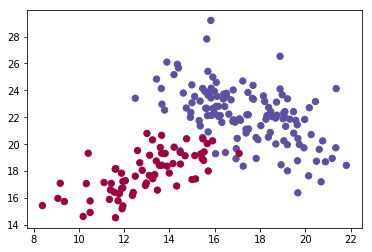

In [2]:
# Generate a dataset and plot it
N = 400        # total number of data points
n1 = 150       # number of data points in class 1
n2 = 250       # number of data points in class 2

# Generate data for class 1
x1, x2 = np.random.multivariate_normal([13, 18], [[2, 3], [3, 2]], n1).T
X1 = np.stack((x1,x2), axis=1)
y1 = np.zeros([n1,])

# Generate data for class 2
x3, x4 = np.random.multivariate_normal([17, 22], [[2, -5], [-4, 2]], n2).T
X2 = np.stack((x3,x4), axis=1)
y2 = np.ones([n2,])

# Compile data into single X, y variables and shuffle
X = np.concatenate((X1,X2), axis=0)
y = np.concatenate((y1,y2), axis=0)

shuffle = np.random.permutation(N)

X = X[shuffle,:]
y = y[shuffle]


# Split data evenly into training and testing sets.
Xtrain = X[0:200,:]
ytrain = y[0:200]
Xtest = X[200:,:]
ytest = y[200:,]

# Plot data
plt.scatter(Xtrain[:,0], Xtrain[:,1], s=40, c=ytrain, cmap=plt.cm.Spectral)
plt.show()


In [3]:
# This function will plot the decision boundary of your classifier. Don't touch it :)
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.05
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

## LDA Classifier
LDA can be used as a Bayesian classifier, just like the Naive Bayes classifier, but it makes different assumptions about the distribution of the data. LDA no longer assumes that the features of each point are independent, but instead assumes that they are drawn from a multivariate normal distribution. Furthermore, it assumes that the data are _homoscedastic_, which simply means that the variance is the same across classes.

$$P(X\,|\,Y=k) \sim \mathcal{N}(\mu_k, \Sigma) $$

Then, using Bayes rule, we can get the posterior probability if we have the prior class probability $P(Y=k)$ and the likelihood $P(X\,|\,Y=k)$. (Note, we can get the marginal probability $P(X)$ simply by summing the likelihood  over $k$.)
$$P(Y=k\,|\,X) = \frac{P(X\,|\,Y=k) \cdot P(Y=k)}{P(X)}$$

The MLE parameters for LDA are:
$$
    \pi_j = \frac{N_j}{N}
$$

$$
    \mu_j = \frac{1}{N_j} \sum_{n=1}^N I(y^{(n)} = j) x^{(n)}
$$

$$
    \Sigma = \frac{1}{N} \sum_{n=1}^N \left[(x^{(n)} - \mu_{y^{(n)}}) (x^{(n)} - \mu_{y^{(n)}})^T\right]
$$



In [4]:
def compute_class_priors(X,y):
    """ Compute the class prior probabilities
        
        Input: 
            X: a NxD matrix, where each row represents a single D-dimensional data point
            y: a Nx1 vector, where each element represents the label for the corresponding D-dimensional data point
        
        Output:
            class_priors: a dictionary with (key,value) pairs representing the class label and prior probability 
            respectively. Key is label, value is prior probability for that class.
    """
    class_priors = dict()
    
    # TODO: compute prior for every class
    class_priors["one"] = np.sum(y) / y.size
    class_priors["zero"] = (y.size - np.sum(y)) / y.size

    return class_priors


In [5]:
def compute_class_means(X,y):
    """ Compute the class means
        
        Input: 
            X: a NxD matrix, where each row represents a single D-dimensional data point
            y: a Nx1 vector, where each element represents the label for the corresponding D-dimensional data point
        
        Output:
            class_means: a dictionary with (key,value) pairs representing the class label and mean respectively. Key
            is label, value is class mean (a numpy vector/array)
    """
    class_means = dict()
    
    # TODO: compute mean for every class
    y = y.reshape(len(y), 1)
    dp = np.concatenate((y,X), axis = 1)
    zero = []
    one = []
    for d in dp:
        if d[0] == 0:
            zero.append(d[1:])
        elif d[0] == 1:
            one.append(d[1:])
    class_means["zero"] = (1 / float(len(zero))) * np.sum(zero, axis = 0)
    class_means["one"] = (1 / float(len(one))) * np.sum(one, axis = 0)
    return class_means

In [6]:
def compute_covariance(X,y,class_means):
    """ Compute the covariance matrix
        Note: the outer product function from the numpy library (i.e. np.outer()) 
              might be useful.
        
        Input: 
            X: a NxD matrix, where each row represents a single D-dimensional data point
            y: a Nx1 vector, where each element represents the label for the corresponding D-dimensional data point
            class_means: a dictionary with (key,value) pairs representing the class label and mean respectively
            
        Output:
            covariance: a DxD covariance matrix for the data
    """
    covariance = np.zeros([X.shape[1],X.shape[1]])
    
    # TODO: Compute covariance matrix
    y = y.reshape(y.size, 1)
    dp = np.concatenate((y, X), axis = 1)
    zero = []
    one = []
    for d in dp:
        if d[0] == 0:
            zero.append(d[1:])
        elif d[0] == 1:
            one.append(d[1:])
    zero = np.array(zero)
    one = np.array(one)
    meanZero = (1 / float(len(zero))) * np.sum(zero, axis = 0)
    meanOne = (1 / float(len(one))) * np.sum(one, axis = 0)
    newZero = np.concatenate((np.zeros((zero.shape[0], 1), dtype = int), zero - meanZero), axis = 1)
    newOne = np.concatenate((np.ones((one.shape[0], 1), dtype = int), one - meanOne), axis = 1)
    newDP = np.concatenate((newZero, newOne), axis = 0)
    covariance = (1 / float(y.shape[0])) * np.dot(newDP[:,1:].T, newDP[:,1:])
    return covariance

In [7]:
def train_LDA(X, y):
    """ Train the parameters for LDA
        There are no input-params. The variable is kept for compatibility reasons.
        
        Input: 
            X: a NxD matrix, where each row represents a single D-dimensional data point
            y: a Nx1 vector, where each element represents the label for the corresponding D-dimensional data point
        Output:
            model: dictionary that holds model parameters
    """
    model = {};
    
    model["priors"] = compute_class_priors(X, y);
    model["means"] = compute_class_means(X, y);
    model["covariance"] = compute_covariance(X,y,model["means"]);
    
    return model;

In [8]:
def predict_LDA(model, X):
    """ Takes a set of data points and predicts a label (0 or 1) for each. A data point has
        a predicted class of 1 if the posterior probability of the point when y=1 is greater 
        than when y=0. Otherwise, the label is 0.
        
        Input: 
            model : dictionary of key/values pairs, containing:
                class_priors: a dictionary with (key,value) pairs representing the class label and prior probability respectively
                class_means: a dictionary with (key,value) pairs representing the class label and mean respectively
                covariance: a DxD covariance matrix for the data
            X: a NxD matrix, where each row represents a single D-dimensional data point
            
        Output:
            yhat: a Nx1 vector whose i'th value is the label (0 or 1) for the i'th datapoint in X
    """
    
    class_priors, class_means, covariance = model["priors"], model["means"], model["covariance"]
    
    yhat = np.zeros(X.shape[0])
    
    # TODO: predict a label for each data point in X and store in yhat
    likeZero = multN.pdf(X, mean = class_means["zero"], cov = covariance)
    likeOne = multN.pdf(X, mean = class_means["one"], cov = covariance)
    derivativeLike = pan.DataFrame()
    derivativeLike["zero"] = likeZero
    derivativeLike["one"] = likeOne
    posteriorZero = likeZero * class_priors["zero"]
    posteriorOne = likeOne * class_priors["one"]
    posterior = np.column_stack((posteriorZero, posteriorOne))
    yhat = np.array([0 if p[0] > p[1] else 1 for p in posterior])
          
    return yhat

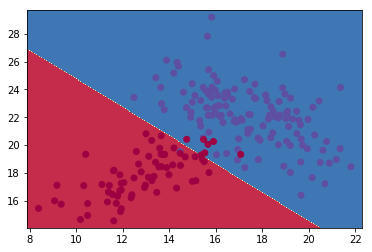

In [9]:
model_LDA = train_LDA(Xtrain, ytrain);
plot_decision_boundary(lambda x: predict_LDA(model_LDA, x), Xtrain, ytrain)

## QDA Classifier
QDA is another Bayesian classifier similar to LDA, but it relaxes the assumption that the classes have the same variance. That is, each class has its own covariance matrix,
$$P(X\,|\,Y=k) \sim \mathcal{N}(\mu_k, \Sigma_k) $$

The MLE parameters for QDA are similar to LDA, except for the covariance matrix, which is now:
$$
    \Sigma_j = \frac{1}{N_j} \sum_{n=1}^N I(y^{(n)} = j) \left[(x^{(n)} - \mu_j) (x^{(n)} - \mu_j)^T\right]
$$


In [10]:
def compute_class_covariances(X,y,class_means):
    """ Compute a covariance matrix for each class
        
        Input: 
            X: a NxD matrix, where each row represents a single D-dimensional data point
            y: a Nx1 vector, where each element represents the label for the corresponding D-dimensional data point
            class_means: a dictionary with (key,value) pairs representing the class label and mean respectively
            
        Output:
            class_covariances: a dictionary with (key,value) pairs representing the class label and its DxD 
            covariance matrix respectively. Key is label, value is DxD matrix
    """
    class_covariances = dict()
    
    # TODO: Compute a covariance matrix for every class
    y = y.reshape(len(y),1)
    dp = np.concatenate((y,X), axis = 1)
    zero = []
    one = []
    for d in dp:
        if d[0] == 0:
            zero.append(d[1:])
        elif d[0] == 1:
            one.append(d[1:])
    zero = np.array(zero)
    one = np.array(one)
    
    meanZero = (1 / float(len(zero))) * np.sum(zero, axis = 0)
    meanOne = (1 / float(len(one))) * np.sum(one, axis = 0)
    
    newZero = np.concatenate((np.zeros((zero.shape[0], 1), dtype=int), zero - meanZero), axis = 1)
    newOne = np.concatenate((np.ones((one.shape[0], 1), dtype=int), one - meanOne), axis = 1)
    
    class_covariances["zero"] = (1 / float(newZero.shape[0])) * np.dot(newZero[:,1:].T, newZero[:,1:])
    class_covariances["one"] = (1 / float(newOne.shape[0])) * np.dot(newOne[:,1:].T, newOne[:,1:])
    
    return class_covariances

In [11]:
def train_QDA(X, y):
    """ Train the parameters for QDA
        There are no input-params. The variable is kept for compatibility reasons.
        
        Input: 
            X: a NxD matrix, where each row represents a single D-dimensional data point
            y: a Nx1 vector, where each element represents the label for the corresponding D-dimensional data point
        Output:
            model: dictionary that holds model parameters
    """
    model = {};
    
    model["priors"] = compute_class_priors(X, y);
    model["means"] = compute_class_means(X, y);
    model["covariances"] = compute_class_covariances(X,y,model["means"]);
    
    return model;



In [12]:
def predict_QDA(model, X):
    """ Takes a set of data points and predicts a label (0 or 1) for each. A data point has
        a predicted class of 1 if the posterior probability of the point when y=1 is greater 
        than when y=0. Otherwise, the label is 0.
        
        Input: 
            model: QDA model parameters
            X: a NxD matrix, where each row represents a single D-dimensional data point
            
        Output:
            yhat: a Nx1 vector whose i'th value is the label (0 or 1) for the i'th datapoint in X
    """
    
    class_priors, class_means, class_covariances = model["priors"], model["means"], model["covariances"];
    
    yhat = np.zeros(X.shape[0])
    
    # TODO: predict a label for each data point in X and store in yhat   
    likeZero = multN.pdf(X, mean = class_means["zero"], cov = class_covariances["zero"]) 
    likeOne = multN.pdf(X, mean = class_means["one"], cov = class_covariances["one"])  
    posteriorZero = likeZero * class_priors["zero"]
    posteriorOne = likeOne * class_priors["one"]
    posterior = np.column_stack((posteriorZero, posteriorOne))
    yhat = np.array([0 if p[0] > p[1] else 1 for p in posterior])
    return yhat

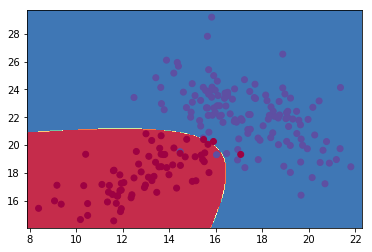

In [13]:

model_QDA = train_QDA(Xtrain, ytrain);

plot_decision_boundary(lambda x: predict_QDA(model_QDA, x), Xtrain, ytrain)

In [14]:
def compute_error(y, yhat):
    """ Compute the loss for the data provided, given the model.
    
        Input:
            y: a Nx1 vector of true class labels
            yhat: a Nx1 vector of predicted class labels
            
        Output:
            A value for the error: average number of misclassifications
    """
    
    # TODO: Compute the error
    return (np.mean(np.absolute(y - yhat)))

In [15]:
LDA_yhat_train = predict_LDA(model_LDA, Xtrain)
LDA_yhat_test = predict_LDA(model_LDA, Xtest)
QDA_yhat_train = predict_QDA(model_QDA, Xtrain)
QDA_yhat_test = predict_QDA(model_QDA, Xtest)

LDA_train_err = compute_error(ytrain, LDA_yhat_train)
LDA_test_err = compute_error(ytest, LDA_yhat_test)
QDA_train_err = compute_error(ytrain, QDA_yhat_train)
QDA_test_err = compute_error(ytest, QDA_yhat_test)

print('\t TRAIN ERROR \t TEST ERROR')
print ('LDA \t %0.2f \t\t %0.2f'%(LDA_train_err, LDA_test_err))
print ('QDA \t %0.2f \t\t %0.2f'%(QDA_train_err, QDA_test_err))



	 TRAIN ERROR 	 TEST ERROR
LDA 	 0.04 		 0.07
QDA 	 0.02 		 0.07


## Changing the train-test split
What happens if we use a different split of the dataset into training and test points, but still use the previously trained models? How does this affect the error rates for each method?

In [16]:
shuffle2 = np.random.permutation(N)
X2 = X[shuffle2,:]
y2 = y[shuffle2]
X2train = X2[0:200,:]
y2train = y2[0:200]
X2test = X2[200:,:]
y2test = y2[200:,]

LDA_yhat_train2 = predict_LDA(model_LDA, X2train)
LDA_yhat_test2 = predict_LDA(model_LDA, X2test)
QDA_yhat_train2 = predict_QDA(model_QDA, X2train)
QDA_yhat_test2 = predict_QDA(model_QDA, X2test)

LDA_train_err2 = compute_error(y2train, LDA_yhat_train)
LDA_test_err2 = compute_error(y2test, LDA_yhat_test)
QDA_train_err2 = compute_error(y2train, QDA_yhat_train)
QDA_test_err2 = compute_error(y2test, QDA_yhat_test)



print('\t TRAIN ERROR \t TEST ERROR')
print ('LDA \t %0.2f \t\t %0.2f'%(LDA_train_err2, LDA_test_err2))
print ('QDA \t %0.2f \t\t %0.2f'%(QDA_train_err2, QDA_test_err2))


	 TRAIN ERROR 	 TEST ERROR
LDA 	 0.46 		 0.47
QDA 	 0.47 		 0.49


# Part 2: Cross Validation
In this part of this assignment, you will perform $k$-fold cross-validation to evaluate your trained models. As we saw before, the performance of a trained model on held out test data might differ depending on which points are used for training and testing (even when the train and test points were drawn from the exact same distribution!). This makes it difficult to confidently report the test accuracy of a model.

To get around this, we split the data into $k$ "folds". Then, in each of $k$ rounds, we assign the datapoints in one fold to be test points and train on the remaining $k-1$ folds of data. This gives us $k$ values for the test error, and we take the average over these values to be the overall test error of the classifier. This lets us use each available datapoint as a test datapoint exactly once, giving a more "complete" picture of the model's performance on data.

In [17]:
def create_k_folds(X,y,k):
    """ Separate data into K folds
    
        Input:
            X:      a NxD matrix, where each row represents a single D-dimensional data point
            y:      a Nx1 vector, where each element represents the label for the corresponding D-dimensional data point
            k:      number of folds
        Output:
            A dictionary of keys where each key is a "fold". A fold is represented as an array of indices that 
            represent the data points in X,y that form the validation set for the current fold.
            
            E.g. Assume we have two folds, and 10 data points, then
            
            output = {
                0   :  [1,2,3,4,5]
                1   :  [6,7,8,9,10]
            }
    """
    
    fold_idxs = dict()
    shuffle = np.random.permutation(N)


    # TODO: shuffle is an array of shuffled indices. Break it into consecutive proportions (folds), 
    # and assign the first partition to fold 0, second partition to fold 1, etc...
    split = np.array_split(shuffle, k)
    for key, value in enumerate(split):
        fold_idxs[key] = value
    return fold_idxs

In [18]:
def run_k_fold_cv(X,y,K, train_func, pred_func):
    """ Run K-fold cross validation, and report training/validation errors for all folds, 
        and return the best-performing model.
        
        Input:
                    
            X:          a NxD matrix, where each row represents a single D-dimensional data point
            y:          a Nx1 vector, where each element represents the label for the corresponding D-dimensional data point
            k:          number of folds
            train_func: The training function
            pred_func:  The prediction function
        
        Output:
            A dictionary of items containing the following key-value pairs:
                'k'          =>  integer
                'errors'     =>  {'fold' => {'training error' => float, 'validation error' => float}}
                'best model' =>  dictionary of model parameters (output of training function)
                'best error' =>  best validation error
    """
    
    output = {
        "k" : K,
        "errors" : {},
        "best model" : {},
        "best error" : float('inf')
    };
    
    # TODO: Run training/prediction for all folds, and fill in the information for the output dictionary
    fold_idxs = create_k_folds(X,y,K)
    model = {}
    for k in range(K):
        Xtrain = X[[i for i in range(X.shape[0]) if i not in fold_idxs[k]]]
        ytrain = y[[i for i in range(X.shape[0]) if i not in fold_idxs[k]]]
        Xtest = X[fold_idxs[k]]
        ytest = y[fold_idxs[k]]
        trainingModel = train_func(Xtrain, ytrain)  
        trainingError = compute_error(ytrain, pred_func(trainingModel, Xtrain))
        testingError = compute_error(ytest, pred_func(trainingModel, Xtest))
        output["errors"][k] = {"training": trainingError, "validation": testingError}
        model[k] = trainingModel 
    err = pan.DataFrame(output["errors"]).T
    output["best model"] = model[err["validation"].idxmin()]
    output["best error"] = err["validation"].min()
    return output;

In [19]:
K = 3

kfold_LDA = run_k_fold_cv(X,y,K, train_LDA, predict_LDA);
kfold_QDA = run_k_fold_cv(X,y,K, train_QDA, predict_QDA);

def list_errors(error_per_fold, key):
    return [error_per_fold[k][key] for k in error_per_fold.keys()]

LDA_mean_train_error = np.mean(list_errors(kfold_LDA["errors"], "training"));
LDA_mean_test_error = np.mean(list_errors(kfold_LDA["errors"], "validation"));

QDA_mean_train_error = np.mean(list_errors(kfold_QDA["errors"], "training"));
QDA_mean_test_error = np.mean(list_errors(kfold_QDA["errors"], "validation"));

LDA_min_test_error = np.min(list_errors(kfold_LDA["errors"], "validation"));
QDA_min_test_error = np.min(list_errors(kfold_QDA["errors"], "validation"));

LDA_max_test_error = np.max(list_errors(kfold_LDA["errors"], "validation"));
QDA_max_test_error = np.max(list_errors(kfold_QDA["errors"], "validation"));


print('\t TRAIN ERROR (Avg) \t VAL ERROR (Avg) \t VAL ERROR (MIN) \t VAL ERROR (MAX)')
print ('LDA \t %0.2f \t\t\t %0.2f \t\t\t %0.2f \t\t\t %0.2f'%(LDA_mean_train_error, LDA_mean_test_error, LDA_min_test_error, LDA_max_test_error))
print ('QDA \t %0.2f \t\t\t %0.2f \t\t\t %0.2f \t\t\t %0.2f'%(QDA_mean_train_error, QDA_mean_test_error, QDA_min_test_error, QDA_max_test_error))
    

	 TRAIN ERROR (Avg) 	 VAL ERROR (Avg) 	 VAL ERROR (MIN) 	 VAL ERROR (MAX)
LDA 	 0.05 			 0.05 			 0.02 			 0.08
QDA 	 0.04 			 0.05 			 0.04 			 0.07


# Comment on your results (final table)
Specifically, what does this tell you about the whole training/testing procedure.

For LDA, the graph obtained is a linear split of the data. It seems to have accurately split the data accordingly to create a linear representation of the data split. Each section of data fits most of the data points in it correctly in training resulting in a train error (avg) of 0.05. the Val error (avg) is also 0.05, (min) is at 0.02, and (max) is at 0.08. these are good errors due to them being so low. The min is low (0.02) from it most accurately grouping this data. and the max is at a high of (0.08) due to this being the least accurate grouping of the data. 

For QDA, the graph obtained is a quadradic split of the data. It also seems to have accurately split the data accordingly. In this one there only seems to be two blue data points and two or three red data points out of place in the training. This resulted in the training error (avg) of 0.04. the val error (avg) is at 0.05, (min) is 0.04, and (max) 0.07. The min is low (0.04) from its most accurate goruping of the data and the max is at (0.07) from its least accurate goruping of the data. 

Overall the training and testing procedure tells us how accurately the model trained on the data set to give the resulting prediciton on the testing dataset. The varying accuracies will tell us how well the model did based on those accuracies.
And finally, I've learned that hell is a cruel place and this hw brought me there and back. #IHateDiscriminentAnalysis&CV 